# Forcasting using LSTM model

Epoch 1/100


<ipython-input-15-d3ffcf4ef3f6>:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Name'] = pd.to_datetime(df['Name'])  # Convert 'Date' to datetime objects
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0298
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0066
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0031
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 0.0019
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - loss: 7.9172e-04
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 7.4087e-04
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 6.7390e-04
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 6.4505e-04
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 5.7724e-04
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.3700e-04
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 6.0049e-04
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 6.1968e-04
Epoch 13/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 6.1991e-04
Epoch 14/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.2372e-04
Epoch 15/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - l

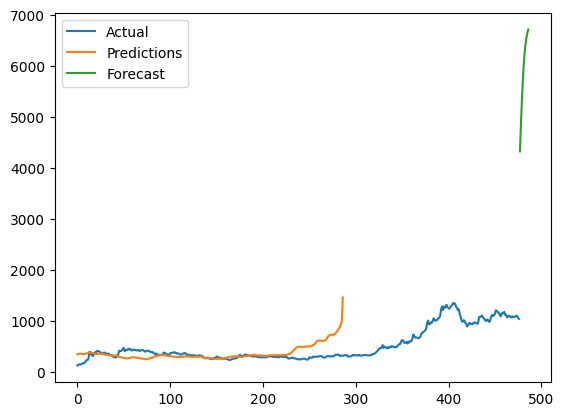

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/content/data_original (1) (1).csv')

# Preprocessing (similar to previous responses)
df['Name'] = pd.to_datetime(df['Name'])  # Convert 'Date' to datetime objects
df.set_index('Name', inplace=True)
data = df[['Euro']].values  # Extract the 'Close' column for forecasting

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Split data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[0:train_size, :], data[train_size:len(data), :]

# Create the dataset with lookback
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    # Adjust the loop to handle smaller test datasets
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 100  # Number of previous days to consider

# Reduce look_back if it's larger than test_data size
look_back = min(look_back, len(test_data) - 2) # -2 to accomodate for the i + look_back index in create_dataset

X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


# Build and train the LSTM model (similar to previous responses)
# Define the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=32)


# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

# Forecasting
# Assuming you want to forecast for the next 'n_future' steps
n_future = 10  # Number of future steps to forecast

# Get the last 'look_back' values from the dataset
future_inputs = data[-look_back:]

# Reshape the inputs for the LSTM model
future_inputs = future_inputs.reshape((1, look_back, 1))

# Generate predictions for 'n_future' steps
future_predictions = []
for _ in range(n_future):
    prediction = model.predict(future_inputs)
    future_predictions.append(prediction[0, 0])

    # Update the inputs with the latest prediction
    future_inputs = np.append(future_inputs[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# Invert the future predictions to the original scale
future_predictions = []
for _ in range(n_future):
    prediction = model.predict(future_inputs)
    future_predictions.append(prediction[0, 0])

    # Update the inputs with the latest prediction
    future_inputs = np.append(future_inputs[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# Convert future_predictions to a NumPy array before reshaping
future_predictions = np.array(future_predictions) # This line is added to fix the error

# ... (rest of the code) ...
future_predictions = scaler.inverse_transform(future_predictions.reshape(-1, 1))

# Visualization
plt.plot(df['Euro'].values, label='Actual')  # Assuming 'Close' is the target variable # Changed to 'Euro' as per data
plt.plot(np.concatenate((train_predict.flatten(), test_predict.flatten())), label='Predictions') # flatten to make dimensions compatible
plt.plot(np.arange(len(data), len(data) + n_future), future_predictions.flatten(), label='Forecast') # flatten to make dimensions compatible
plt.legend()
plt.show()